<a href="https://www.kaggle.com/code/kavishchaudhary1003/playground-s3-e11-optuna-xgb-lgbm-catboost?scriptVersionId=123347840" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm 
import optuna
from sklearn.metrics import mean_squared_log_error

import os
for dirname, _, filenames in os.walk('/kaggle/input/playground-series-s3e11'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e11/sample_submission.csv
/kaggle/input/playground-series-s3e11/train.csv
/kaggle/input/playground-series-s3e11/test.csv


# Competition Page
https://www.kaggle.com/competitions/playground-series-s3e11/overview/description

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e11/test.csv')

### Drop id from train and test set

In [3]:
train.drop(columns = ['id'], inplace = True)
test.drop(columns = ['id'], inplace = True)

### Checking for null and duplicates

In [4]:
train.isna().sum()
train.duplicated().sum()

0

In [5]:
for i in train.columns :
    print(train[i].value_counts())

5.04     2373
5.40     1988
7.41     1919
7.95     1874
5.52     1831
         ... 
3.79        1
5.45        1
16.15       1
2.02        1
5.77        1
Name: store_sales(in millions), Length: 1044, dtype: int64
3.0    175556
4.0     94999
2.0     77240
1.0      6765
5.0      5745
6.0        31
Name: unit_sales(in millions), dtype: int64
1.0    74857
2.0    73902
3.0    71524
4.0    70134
0.0    36441
5.0    33478
Name: total_children, dtype: int64
0.0    243555
1.0     49427
2.0     28163
3.0     20382
4.0     12532
5.0      6277
Name: num_children_at_home, dtype: int64
2.0    110401
3.0    104424
1.0     82619
4.0     44355
0.0     18537
Name: avg_cars_at home(approx).1, dtype: int64
17.10    4372
14.70    3906
19.90    3800
17.20    3616
13.70    3516
         ... 
12.01       1
10.98       1
10.01       1
9.08        1
9.60        1
Name: gross_weight, Length: 384, dtype: int64
1.0    204702
0.0    155634
Name: recyclable_package, dtype: int64
0.0    242219
1.0    118117
Name: low

### Summary stats

In [6]:
train.describe()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
count,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000,360336.000000
mean,6.337376,3.043881,2.456482,0.689390,2.203813,13.822071,0.568086,0.327797,18.972706,28180.333442,0.564839,0.277394,0.504807,0.504832,0.503191,99.614729
std,3.307980,0.784676,1.488992,1.214732,1.084293,4.614792,0.495343,0.469411,10.212912,5968.874074,0.495779,0.447713,0.499978,0.499977,0.499991,29.939435
min,0.510000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,20319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.790000
25%,3.720000,3.000000,1.000000,0.000000,1.000000,9.710000,0.000000,0.000000,10.000000,23593.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.320000
50%,5.780000,3.000000,2.000000,0.000000,2.000000,13.600000,1.000000,0.000000,20.000000,27694.000000,1.000000,0.000000,1.000000,1.000000,1.000000,98.810000
75%,8.400000,4.000000,4.000000,1.000000,3.000000,17.700000,1.000000,1.000000,28.000000,33858.000000,1.000000,1.000000,1.000000,1.000000,1.000000,126.620000
max,22.920000,6.000000,5.000000,5.000000,4.000000,21.900000,1.000000,1.000000,36.000000,39696.000000,1.000000,1.000000,1.000000,1.000000,1.000000,149.750000


### Plotting the  continuous predictor variables

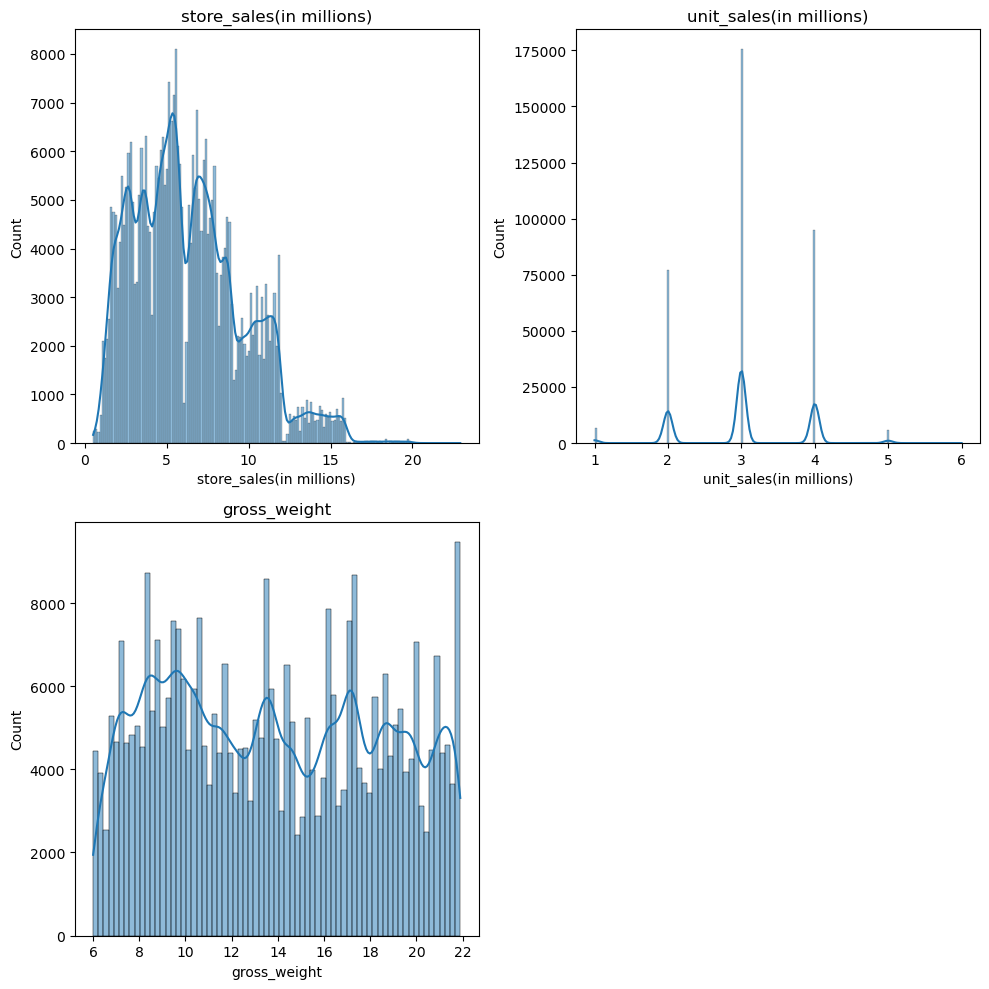

In [7]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (10,10))
for i, ax in enumerate(axes.flat):
    if i < len(['store_sales(in millions)', 'unit_sales(in millions)','gross_weight']):
        sns.histplot(x = train[(['store_sales(in millions)', 'unit_sales(in millions)','gross_weight'])[i]], kde = True, ax= ax)
        ax.set_title(['store_sales(in millions)', 'unit_sales(in millions)','gross_weight'][i])
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()
        

### Plotting the  boxplot of continuous predictor variables

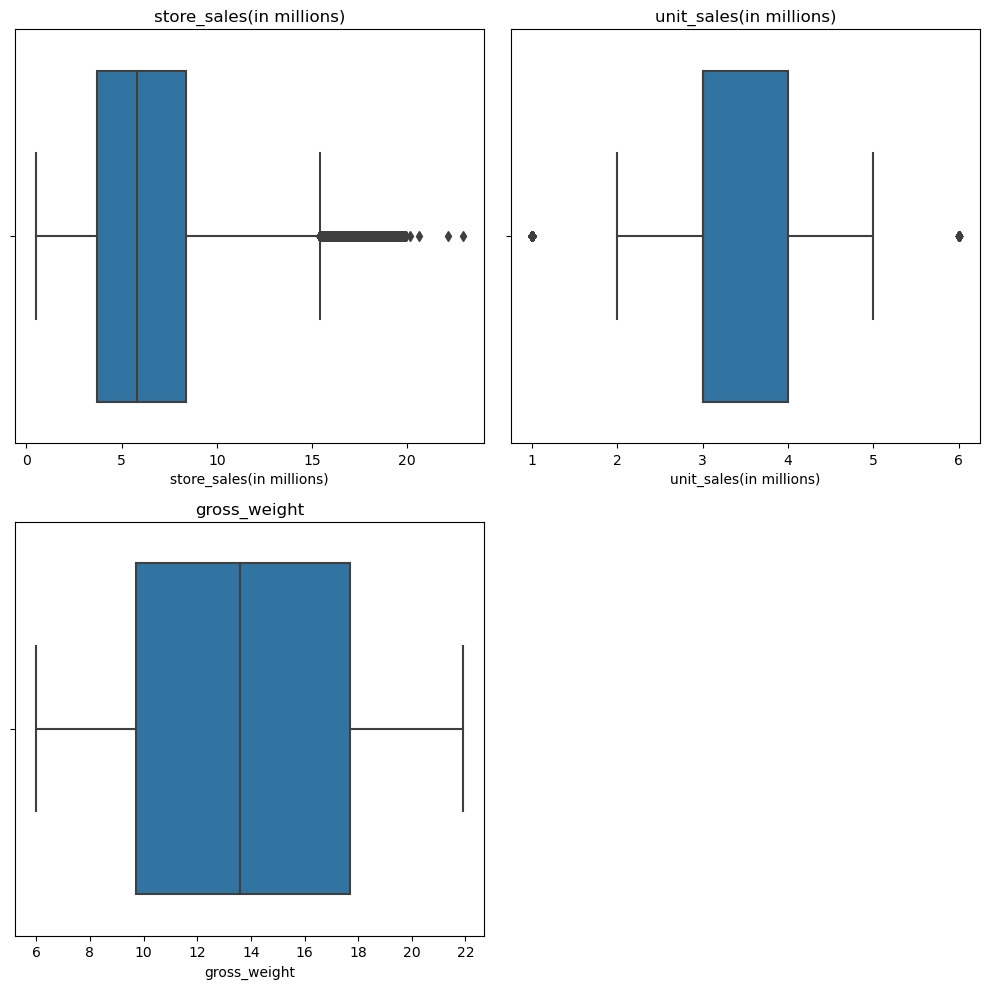

In [8]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (10,10))
for i, ax in enumerate(axes.flat):
    if i < len(['store_sales(in millions)', 'unit_sales(in millions)','gross_weight']):
        sns.boxplot(x = train[(['store_sales(in millions)', 'unit_sales(in millions)','gross_weight'])[i]], ax= ax)
        ax.set_title(['store_sales(in millions)', 'unit_sales(in millions)','gross_weight'][i])
    else:
        axes.flat[i].set_visible(False)
plt.tight_layout()
plt.show()

### Plotting the categorical predictor variables

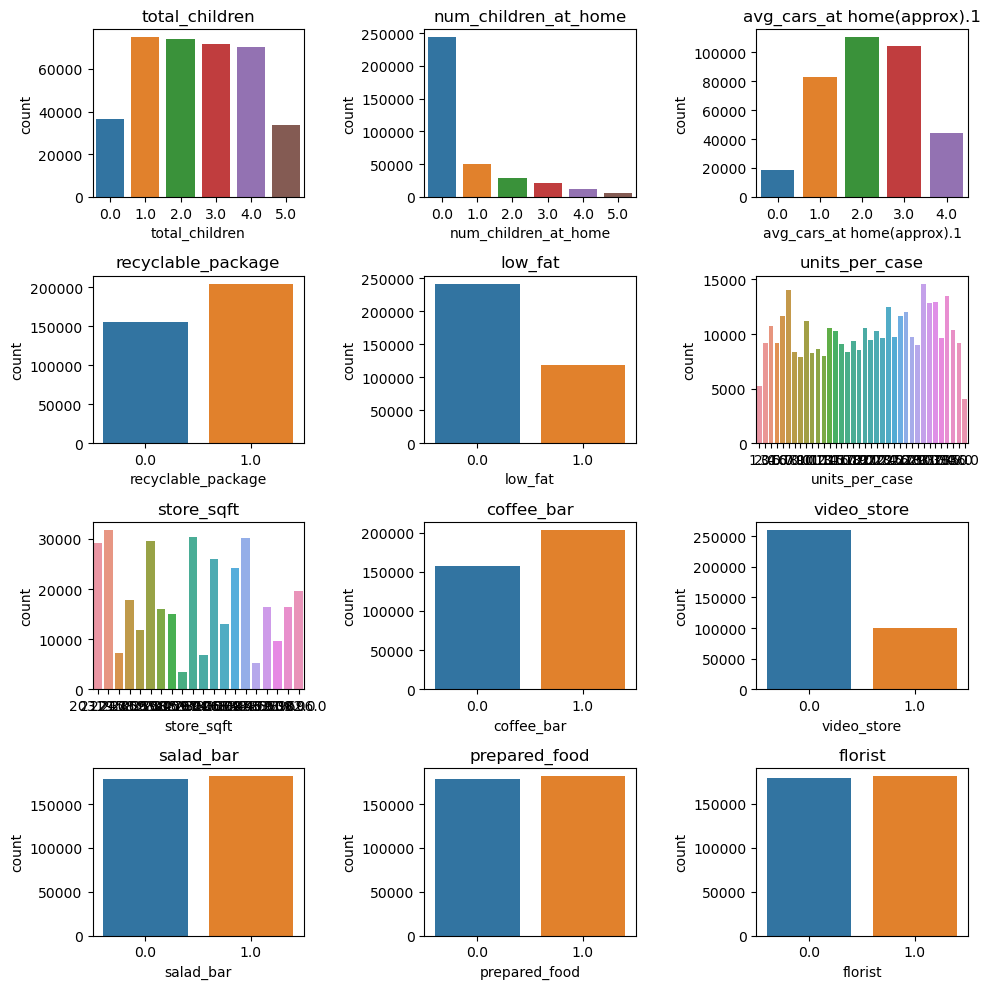

In [9]:
fig, axes = plt.subplots(ncols = 3, nrows = 4, figsize= (10,10))
for i, ax in enumerate(axes.flat):
    if i < len([ 'total_children','num_children_at_home', 'avg_cars_at home(approx).1',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft',
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']):
        sns.countplot(x = train[([ 'total_children','num_children_at_home', 'avg_cars_at home(approx).1',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft',
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist'])[i]], ax=ax)
        ax.set_title([ 'total_children','num_children_at_home', 'avg_cars_at home(approx).1',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft',
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist'][i])
    else:
        ax.set_visible(False)
plt.tight_layout()
plt.show()

### Plotting the target variable

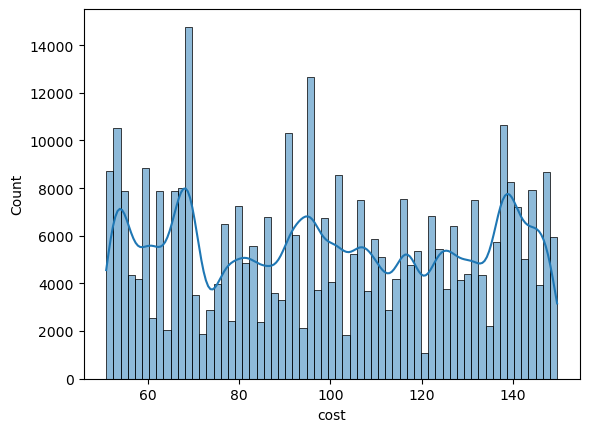

In [10]:
sns.histplot(x= train.cost, kde = True)
plt.show()

### Separating features and target variable

In [11]:
y = train.cost
train.drop(columns = ['cost'], inplace = True)

### Target encoding the categorical variables

In [ ]:
te = TargetEncoder(cols = [ 'total_children','num_children_at_home', 'avg_cars_at home(approx).1',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft',
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist'])
te.fit(train, (y))
train[['store_sales(in millions)', 'unit_sales(in millions)', 'total_children',
       'num_children_at_home', 'avg_cars_at home(approx).1', 'gross_weight',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft',
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']] = te.transform(train[['store_sales(in millions)', 'unit_sales(in millions)', 'total_children',
       'num_children_at_home', 'avg_cars_at home(approx).1', 'gross_weight',
       'recyclable_package', 'low_fat', 'units_per_case', 'store_sqft',
       'coffee_bar', 'video_store', 'salad_bar', 'prepared_food', 'florist']])
test = te.transform(test)


### Optuna parameter tuning- XG Boost

In [ ]:
def obj_xg(trial):
    params= {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'gamma': trial.suggest_float('gamma', 1e-5, 2),
        'min_child_weight': trial.suggest_int('min_child_weight', 1,20),
        'subsample': trial.suggest_float('subsample', 0,1),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0,1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0,1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    scores = []
    optuna_model = XGBRegressor(**params, objective = 'reg:squaredlogerror')
    cv= KFold(n_splits = 10, shuffle = True, random_state = 0)
    for train_index,test_index in cv.split(train,y):
        trainx, testx = train.iloc[train_index],train.iloc[test_index]
        trainy, testy = y[train_index], y[test_index]
        optuna_model.fit(trainx, trainy)
        predy = optuna_model.predict(testx)
        scores.append(mean_squared_log_error(testy, predy, squared = False))
    return np.mean(scores)
study_xg = optuna.create_study(direction = 'minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
n_trials = 20
with tqdm(total = n_trials) as pbar:
    for i in range(n_trials):
        study_xg.optimize(obj_xg, n_trials=1)
        pbar.update(1)

### Optuna parameter tuning- Light GBM

In [ ]:
def obj_light(trial):
    params ={
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.1,1),
        'n_estimators': trial.suggest_int('n_estimators', 200,1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0,1)
    }
    optuna_model = LGBMRegressor(**params)
    cv = KFold(n_splits = 10, shuffle = True, random_state = 0)
    scores = []
    for train_index, test_index in cv.split(train,y):
        trainx, testx = train.iloc[train_index], train.iloc[test_index]
        trainy, testy = y[train_index], y[test_index]
        optuna_model.fit(trainx, trainy)
        predy = optuna_model.predict(testx)
        scores.append(mean_squared_log_error(testy, predy, squared = False))
        return np.mean(scores)
study_light = optuna.create_study(direction = 'minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
n_trials = 50
with tqdm(total = n_trials) as pbar:
    for i in range(n_trials):
        study_light.optimize(obj_light, n_trials = 1)
        pbar.update(1)

### Optuna parameter tuning- Cat Boost

In [ ]:
def obj_cat(trial):
    params={
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0,1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01,0.1),
        'depth': trial.suggest_int('depth', 1, 10)
    }
    optuna_model = CatBoostRegressor(**params, verbose = False)
    cv = KFold(n_splits = 10, shuffle = True, random_state = 0)
    scores = []
    for train_index, test_index in cv.split(train, y):
        trainx, testx = train.iloc[train_index], train.iloc[test_index]
        trainy, testy = y[train_index], y[test_index]
        optuna_model.fit(trainx, trainy)
        predy = optuna_model.predict(testx)
        scores.append(mean_squared_log_error(testy, predy, squared = False))
    return np.mean(scores)
study_cat = optuna.create_study(direction = 'minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
n_trials = 50
with tqdm(total = n_trials) as pbar:
    for i in range(n_trials):
        study_cat.optimize(obj_cat, n_trials = 1)
        pbar.update(1)

### Predicting the values for the test set

In [ ]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 0)
pred_xgb = np.zeros(test.shape[0])
pred_cat = np.zeros(test.shape[0])
pred_lgb = np.zeros(test.shape[0])
rmle_xgb=[]  
rmle_cat=[]
rmle_lgb=[]
rmle = []
n=0

for train_index, test_index in cv.split(train, y):
    trainx, testx = train.iloc[train_index], train.iloc[test_index]
    trainy, testy = y[train_index], y[test_index] 
    
    # XGBoost regressor
    model_xgb = XGBRegressor(early_stopping_rounds=100, **study_xg.best_params)
    model_xgb.fit(trainx,trainy,eval_set=[(testx, testy)],verbose= False ) 
    pred_xgb+=model_xgb.predict(test)/cv.n_splits
    rmle_xgb.append(mean_squared_log_error(testy, model_xgb.predict(testx), squared=False))
    
    # CatBoost regressor
    model_cat = CatBoostRegressor(**study_cat.best_params)
    model_cat.fit(trainx,trainy,eval_set=[(testx, testy)],early_stopping_rounds=100,verbose= False ) 
    pred_cat+=model_cat.predict(test)/cv.n_splits
    rmle_cat.append(mean_squared_log_error(testy, model_cat.predict(testx), squared=False))
    
    
    # LightGBM regressor
    model_lgb = LGBMRegressor(**study_light.best_params)
    model_lgb.fit(trainx,trainy,eval_set=[(testx,testy)],early_stopping_rounds=100,verbose= False ) 
    pred_lgb+=model_lgb.predict(test)/cv.n_splits
    rmle_lgb.append(mean_squared_log_error(testy, model_lgb.predict(testx), squared=False))
    
    rmle_val = (rmle_xgb[n]+ rmle_cat[n]+ rmle_lgb[n]) / 3    
    rmle.append(rmle_val)
    print(f"fold: {n+1} rmle xgb: {rmle_xgb[n]} | rmle cat: {rmle_cat[n]} | rmle LGBM: {rmle_lgb[n]} final rmle is: {rmle[n]}")
    n+=1

print(np.mean(rmle))

In [ ]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e11/sample_submission.csv')
submission['XGB'] = pred_xgb
submission['cost'] = submission['XGB']
final_submission = pd.DataFrame(submission, columns=['id', 'cost'])
final_submission.to_csv('predictions.csv', index = False)

In [ ]:
submission['CAT'] = pred_cat
submission['cost'] = submission['CAT']
final_submission = pd.DataFrame(submission, columns=['id', 'cost'])
final_submission.to_csv('predictions.csv', index = False)

# The best model

In [ ]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e11/sample_submission.csv')
submission['LGBM'] = pred_lgb
submission['cost'] = submission['LGBM']
final_submission = pd.DataFrame(submission, columns=['id', 'cost'])
final_submission.to_csv('predictions.csv', index = False)